```
Reading a long time series from Lorenz 96 X-values and training a 
neural network to behave as the Lorenz 96 system.

Copyright (C) 2020  SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

Configuration and evaluation of the neural network is taken from:
the [supplementary material](https://www.geosci-model-dev.net/11/3999/2018/gmd-11-3999-2018-discussion.html) for the article *Challenges and design choices for global weather and climate models based on machine learning* by P. Dueben and P. Bauer, published in [Geosci. Model Dev., 11, 3999–4009, 2018](https://doi.org/10.5194/gmd-11-3999-2018)



In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
import pandas as pd

import math

import tensorflow.keras 
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adagrad, Adadelta
import json

#Helpful during development
import importlib
#importlib.reload(module)

import datetime
import time

from IPython.display import display

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc


import Lorenz96

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
init_X = np.random.normal(loc=0, scale=5, size=8)
init_Y = np.random.normal(loc=0, scale=1, size=(8,8))
init_Z = np.random.normal(loc=0, scale=0.05, size=(8,8,8))

init_X1 = init_X + np.random.normal(loc=0, scale=0.005, size=8)
init_X2 = init_X + np.random.normal(loc=0, scale=0.005, size=8)

In [3]:
# Create Neural-network structure using the global structure
model = Sequential()
model.add(Dense(8, input_dim=8, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(8, activation='tanh'))


In [4]:
# Compile model with stochastic gradient descent
model.compile(loss='mean_absolute_error', optimizer='SGD', metrics=['mae'])


In [5]:
# Load weights
model.load_weights('data/ANN_weights_global_2020_05_04-18_04_47/weights', by_name=False)


In [6]:
### Read init_state and initialize X array
init_folder = 'data/training_data_2020_05_04-15_13_21/'
#normalized_run = np.load(init_folder+'normalized_run.npz')
#init_X = normalized_run['X'][0,:]
#print(init_X.shape, init_X)

statistical_properties = np.load(init_folder+'mean_and_stddev.npz')
mean = statistical_properties['mean']
stddev = statistical_properties['stddev']
print(mean, stddev)

3.5339352806483513 6.840902635767988


In [7]:
print(model.output_shape, model.input_shape)

(None, 8) (None, 8)


In [116]:
class DataDrivenLorenz96:
    
    def __init__(self, data_driven_model, nx=8,
                 end_T=5, init_X=None, 
                 mean=0, stddev=1
                 ):
        
        assert(data_driven_model.output_shape[1] == nx), 'nx does not match the data driven model'
        
        self.nx = nx
        if init_X is not None:
            assert(len(init_X) == self.nx), 'wrong size of init X'
        
        self.dt = 0.005
            
        self.end_T = end_T
        self.num_timesteps = int(self.end_T / 0.005)
        
        # Always store X
        self.X = np.zeros((self.num_timesteps+1, self.nx))
        
        # iteration counter
        self.it = 0
        self.t = 0.0
        
        # Initialzation:
        if init_X is not None:
            self.X[0,:] = init_X
        else:
            self.X[0,:] = np.random.normal(loc=0, scale=1, size=self.nx)
        
        self.mean, self.stddev = mean, stddev
         
        self.time_scheme = 1
        
        self.prev_dx = 0
        self.prev_prev_dx = 0
        
    def step(self, T, keras_step=True, use_multiprocessing=False, batch_size=1):
        
        T_in_iterations = int(T/self.dt)
        num_iterations = T_in_iterations - self.it
        
        tic = time.time()
        
        if self.it + num_iterations > self.num_timesteps:
            print('Asked for too many timesteps \n(allocated, already completed, asked for, would result in, will only do)\n', 
                  self.num_timesteps, self.it, num_iterations, self.it+num_iterations, self.num_timesteps - self.it)
            num_iterations = self.num_timesteps - self.it

        state = np.zeros((1,self.nx))

        for i in range(num_iterations):
            
            state[:] = self.X[self.it, :]
            
            #print(self.X[self.it,:].shape)
            #print(self.X[self.it,:])
            if keras_step:
                # batch_size = 1 seems to be best 
                #    (at least as long state only represent a single state, and not an ensemble)
                latest_dx = model.predict(state, batch_size=batch_size, use_multiprocessing=use_multiprocessing) #, use_multiprocessing=True)
            else:
                latest_dx = self._manual_evaluate_NN(state)
            
            if self.time_scheme == 1:
                dx = latest_dx
                self.time_scheme = 2
            elif self.time_scheme == 2:
                dx = 1.5*latest_dx - 0.5*self.prev_dx
                self.time_scheme = 3
            else:
                dx = (23.0/12.0)*latest_dx-(4.0/3.0)*self.prev_dx+(5.0/12.0)*self.prev_prev_dx
            
            self.X[self.it+1,:] = self.X[self.it,:] + dx
            
            self.prev_prev_dx = self.prev_dx
            self.prev_dx = latest_dx
            self.it += 1
        
    def _manual_evaluate_NN(self, state):
        for layer in model.layers:
            #print('starting layer')
            #w = layer.weights[0].numpy()
            #b = layer.bias.numpy()
            #state = np.tanh(np.dot(state, w) + b)
            
            state = np.tanh(np.dot(state, layer.weights[0].numpy()) + layer.bias.numpy())
        return state  
            
    

In [19]:
%%time
ddL96 = DataDrivenLorenz96(model,  init_X=(init_X-mean)/stddev,  mean=mean, stddev=stddev)
ddL96.step(5)
ddL961 = DataDrivenLorenz96(model, init_X=(init_X1-mean)/stddev, mean=mean, stddev=stddev)
ddL961.step(5)
ddL962 = DataDrivenLorenz96(model, init_X=(init_X2-mean)/stddev, mean=mean, stddev=stddev)
ddL962.step(5)

CPU times: user 49.2 s, sys: 980 ms, total: 50.2 s
Wall time: 47.9 s


In [20]:
%%time
print(init_X)
L96 = Lorenz96.Lorenz96(init_X=init_X, init_Y=init_Y, init_Z=init_Z)
L96.step(5)
L961 = Lorenz96.Lorenz96(init_X=init_X1, init_Y=init_Y, init_Z=init_Z)
L961.step(5)
L962 = Lorenz96.Lorenz96(init_X=init_X2, init_Y=init_Y, init_Z=init_Z)
L962.step(5)

[ 2.28797878 -3.32064209 -0.1391842  -5.07104897 -2.76592566 -5.69763426
  4.12520869 -1.12491214]
CPU times: user 3.83 s, sys: 8 ms, total: 3.84 s
Wall time: 3.83 s


In [119]:
%%time
print(init_X)
single_L96 = Lorenz96.Lorenz96(init_X=init_X, num_layers=1)
single_L96.step(5)
single_L961 = Lorenz96.Lorenz96(init_X=init_X1, num_layers=1)
single_L961.step(5)
single_L962 = Lorenz96.Lorenz96(init_X=init_X2, num_layers=1)
single_L962.step(5)

[ 2.28797878 -3.32064209 -0.1391842  -5.07104897 -2.76592566 -5.69763426
  4.12520869 -1.12491214]
CPU times: user 1.16 s, sys: 0 ns, total: 1.16 s
Wall time: 1.15 s


1000


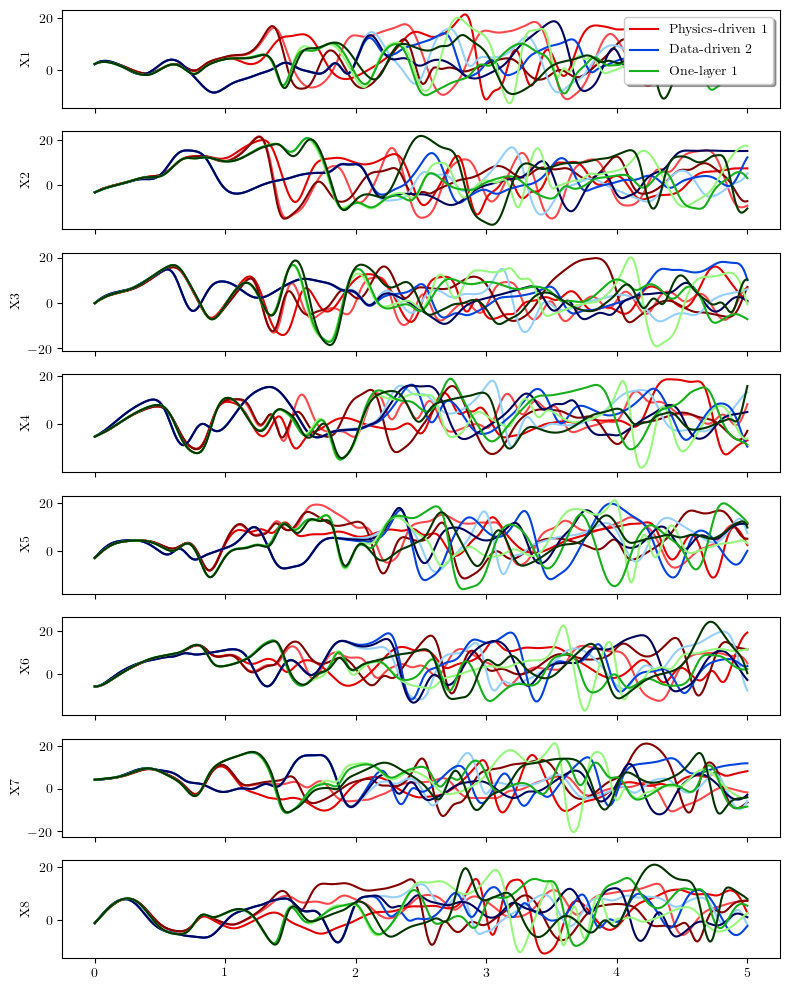

In [130]:
fig, axs = plt.subplots(8, figsize=(8,10), sharex=True)
x_axis = np.arange(L96.num_timesteps+1)*L96.dt
for i in range(8):
    axs[i].plot(x_axis, L96.X[:,i], color='xkcd:light red')#, label='Physics-driven')
    axs[i].plot(x_axis, L961.X[:,i], color='xkcd:red', label='Physics-driven 1')
    axs[i].plot(x_axis, L962.X[:,i], color='xkcd:dark red')# , label='Physics-driven 2')
    axs[i].plot(x_axis, ddL961.X[:,i]*stddev+mean, color='xkcd:light blue') #, label='Data-driven 1')
    axs[i].plot(x_axis, ddL962.X[:,i]*stddev+mean, color='xkcd:blue', label='Data-driven 2')
    axs[i].plot(x_axis, ddL96.X[:,i]*stddev+mean, color='xkcd:dark blue') #, label='Data-driven')
    axs[i].plot(x_axis, single_L96.X[:,i], color='xkcd:light green')#, label='Physics-driven')
    axs[i].plot(x_axis, single_L961.X[:,i], color='xkcd:green', label='One-layer 1')
    axs[i].plot(x_axis, single_L962.X[:,i], color='xkcd:dark green')# , label='Physics-driven 2')    plt.legend(loc=1)
    axs[i].set_ylabel('X'+str(i+1))
    
axs[0].legend(loc=1, shadow=True)
print(ddL96.it)
plt.tight_layout()

# Manual computation of a single step

Let $x$ be input to a layer with weights $w$ and bias $b$. 

Then the output of the layer will be $\sigma(x \cdot w + b)$. 

Here, the activation function $\sigma(\cdot) = \tanh(\cdot)$.

**Here, we check that we get the same time series for keras vs manual evaluation**

In [131]:
in_X = np.zeros((1,8))
in_X[:] = (init_X-mean)/stddev

# Manual:
a = in_X.copy()
for layer in model.layers:
    #print('starting layer')
    w = layer.weights[0].numpy()
    b = layer.bias.numpy()
    
    a = np.tanh(np.dot(a, w) + b)
    print('done layer with shape: ', a.shape)
    
# keras:
dx_from_NN = model.predict(in_X, batch_size=1)

print(dx_from_NN)
print(a)
print(np.linalg.norm(dx_from_NN-a))


done layer with shape:  (1, 8)
done layer with shape:  (1, 100)
done layer with shape:  (1, 100)
done layer with shape:  (1, 100)
done layer with shape:  (1, 100)
done layer with shape:  (1, 8)
[[0.02516193 0.0185146  0.03737732 0.02303226 0.04521643 0.00018593
  0.00165997 0.04041414]]
[[0.02516191 0.01851463 0.03737732 0.02303225 0.04521644 0.00018598
  0.00165995 0.04041411]]
7.195229014538775e-08


In [136]:
%%time
end_T = 10
ddL96_keras = DataDrivenLorenz96(model,  init_X=(init_X-mean)/stddev,  mean=mean, stddev=stddev, end_T=end_T)
ddL96_keras.step(end_T)


CPU times: user 33.3 s, sys: 484 ms, total: 33.8 s
Wall time: 32.2 s


In [137]:
%%time
ddL96_keras_mp = DataDrivenLorenz96(model,  init_X=(init_X-mean)/stddev,  mean=mean, stddev=stddev, end_T=end_T)
ddL96_keras_mp.step(end_T, use_multiprocessing=True)

CPU times: user 33.3 s, sys: 452 ms, total: 33.7 s
Wall time: 32.1 s


In [138]:
%%time
ddL96_manual = DataDrivenLorenz96(model,  init_X=(init_X-mean)/stddev,  mean=mean, stddev=stddev, end_T=end_T)
ddL96_manual.step(end_T, keras_step=False)


CPU times: user 51.7 s, sys: 3.1 s, total: 54.8 s
Wall time: 6.97 s


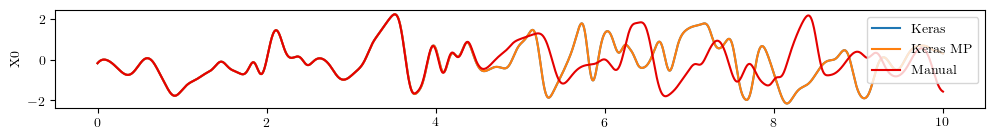

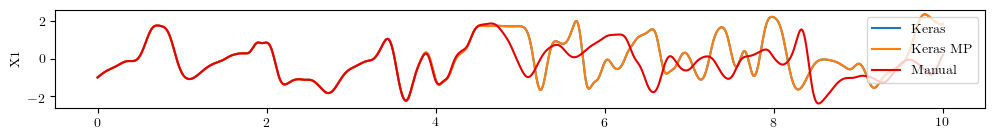

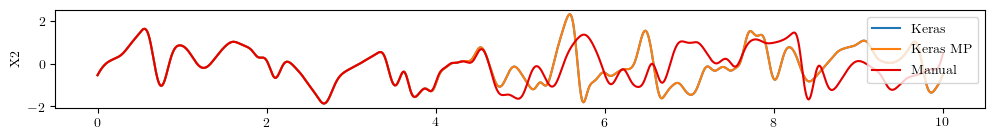

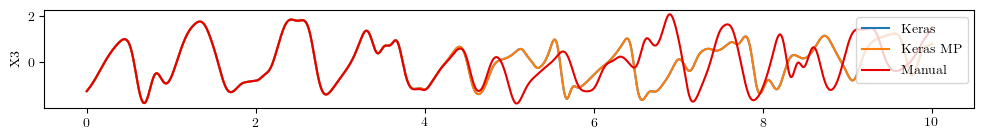

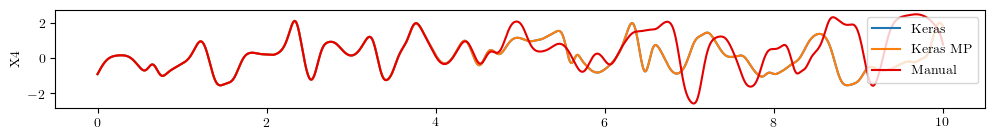

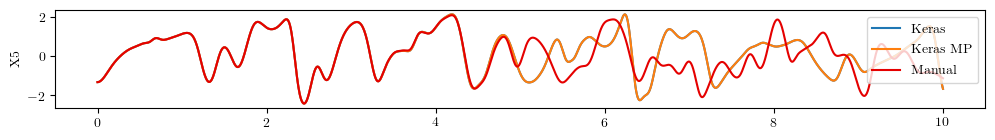

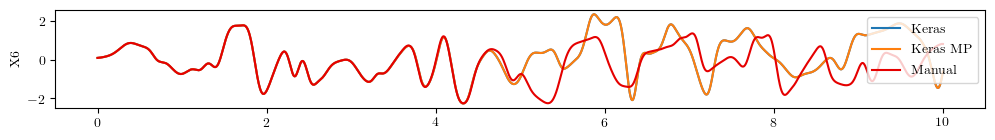

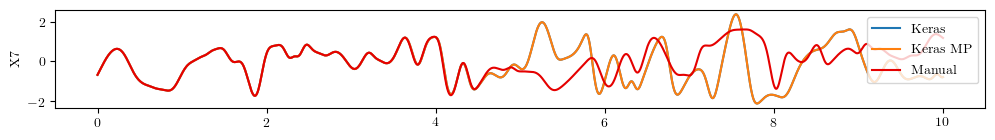

In [139]:
for i in range(8):
    fig = plt.figure(figsize=(12,1.3))
    plt.plot(np.arange(ddL96_keras.num_timesteps+1)*ddL96_keras.dt, ddL96_keras.X[:,i], label='Keras')
    plt.plot(np.arange(ddL96_keras_mp.num_timesteps+1)*ddL96_keras_mp.dt, ddL96_keras_mp.X[:,i], label='Keras MP')
    plt.plot(np.arange(ddL96_manual.num_timesteps+1)*ddL96_manual.dt, ddL96_manual.X[:,i], color='xkcd:red', label='Manual')
    plt.legend(loc=1)
    plt.ylabel('X'+str(i))
